## Импорт библиотек

In [ ]:
import os
import gc
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Config

In [ ]:
TRAIN_TARGET_PATH = '/content/drive/My Drive/Университет/Credit_Scoring/data/train_target.csv'
ALL_TRANSACTIONS_PATH = '/content/drive/My Drive/Университет/Credit_Scoring/data/parquet_all/'


## Просмотр данных

* Загрузим данные о кредитных продуктах клиентов с информацией о том, ушёл ли клиент в дефолт или нет

In [ ]:
target_df = pd.read_csv(TRAIN_TARGET_PATH)


In [ ]:
target_df


,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0
...,...,...,...
963806,1003045,1,0
963807,1003047,0,0
963808,1003048,1,0
963809,1003049,0,0


* загрузка транзакционных данных

In [ ]:
import os
import pandas as pd
import tqdm

def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('part')])  # Получаем список всех файлов, начинающихся с 'part'

    start_from = max(0, start_from)  # Убеждаемся, что стартовая партиция не меньше нуля
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]  # Выбираем нужное количество партиций для чтения
    if verbose:
        print('Reading chunks:\n')  # Если verbose=True, выводим на печать имена партиций
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):  # Читаем партиции с отображением прогресса
        chunk = pd.read_parquet(chunk_path, columns=columns)  # Читаем текущую партицию, возможно, выбирая определенные колонки
        res.append(chunk)  # Добавляем прочитанную партицию в список
    return pd.concat(res).reset_index(drop=True)  # Объединяем все партиции в один DataFrame и сбрасываем индексы



* Для теста прочитаем одну партицию в память и оценим, сколько RAM она занимает

In [ ]:
# Чтение одной партиции данных с транзакциями
transactions_frame = read_parquet_dataset_from_local(ALL_TRANSACTIONS_PATH, start_from=0, num_parts_to_read=1)

# Вычисление объема памяти, занимаемого одной партицией данных
memory_usage_of_frame = transactions_frame.memory_usage(index=True).sum() / 10**9

# Оценка ожидаемого объема памяти для всего датасета, предполагая, что в нем 50 партиций
expected_memory_usage = memory_usage_of_frame * 50

print(f'Объем памяти в RAM одной партиции данных с транзакциями: {round(memory_usage_of_frame, 3)} Gb')
print(f'Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} Gb')


<ipython-input-49-04d7051b5d88>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):  # Читаем партиции с отображением прогресса


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Объем памяти в RAM одной партиции данных с транзакциями: 0.476 Gb
Ожидаемый размер в RAM всего датасета: 23.798 Gb


Как мы видим, только тренировочный дата-сет потребует свободной оперативной памятия почти 24 ГБ.
В бесплатнйо среде гугл-колаба мы ограничены 12 Гб оперативной памяти. Поэтому читать и обрабатывать данные придётся итеративно.

In [ ]:
transactions_frame

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5408643,23646,0.390944,1,1,37,2,1,1,3,1,1,1,3,1,6,9,2,48,32,453
5408644,23646,0.428447,1,1,37,2,1,1,3,1,39,1,120,7,5,12,1,48,27,454
5408645,23646,0.371478,1,1,37,2,1,1,3,1,22,1,2,9,5,13,1,48,1,455
5408646,23646,0.348726,1,1,37,2,1,1,3,1,22,1,3,9,5,13,1,48,1,456


In [ ]:
# Удаление объекта transactions_frame:
del transactions_frame
gc.collect()


12046

* Проверим данные на наличие пропусков

In [ ]:
def check_missing_values(path_to_dataset):
    """
    Проверяет каждую партицию данных на пропущенные значения.
    Если пропущенные значения есть, выводит в консоль название файла, название поля и количество пропущенных значений.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        missing_data = df.isnull().sum()

        for column, missing_count in missing_data.items():
            if missing_count > 0:
                print(f"Файл: {os.path.basename(file_path)}, Поле: {column}, Количество пропущенных значений: {missing_count}")

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

# Проверка пропущенных значений в данных
check_missing_values(ALL_TRANSACTIONS_PATH)


## EDA


### Кредитные продукты клиентов

<ipython-input-57-b2712e26cf79>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette=colors)


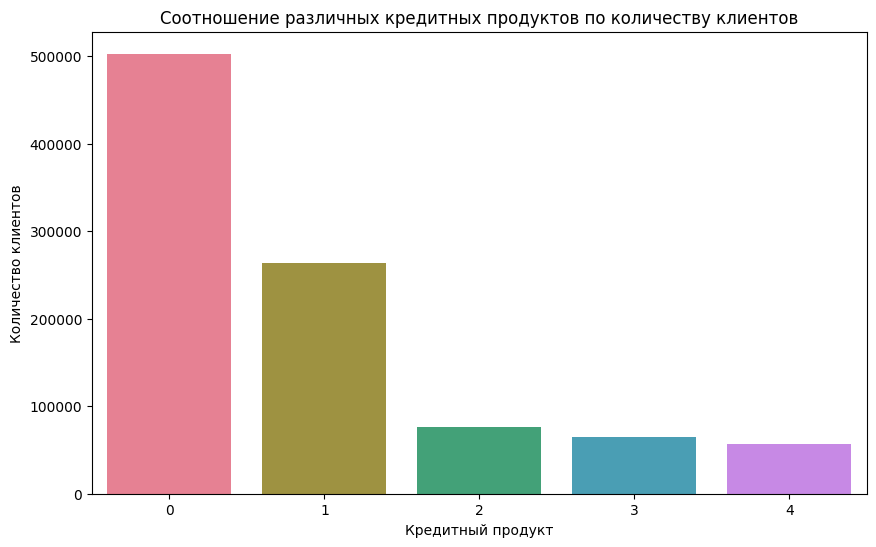

In [ ]:
# Подсчет количества каждого продукта
product_counts = target_df['product'].value_counts()

plt.figure(figsize=(10, 6))
colors = sns.color_palette('husl', len(product_counts))  # Генерация цветовой палитры
sns.barplot(x=product_counts.index, y=product_counts.values, palette=colors)
plt.title('Соотношение различных кредитных продуктов по количеству клиентов')
plt.xlabel('Кредитный продукт')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.show()


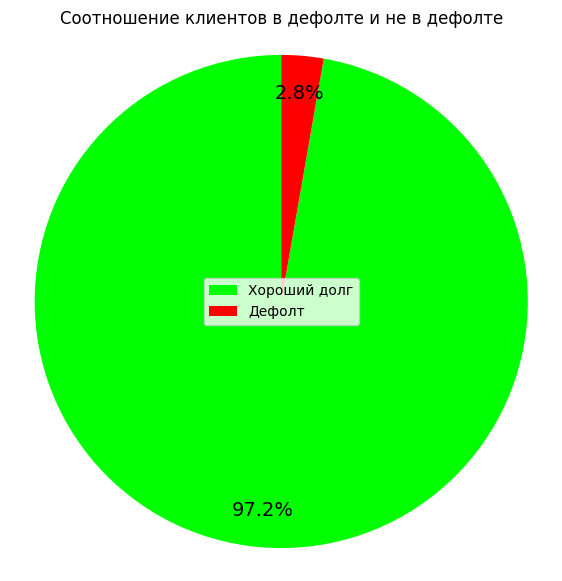

In [ ]:
# Подсчет количества каждого значения в колонке 'flag'
flag_counts = target_df['flag'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(flag_counts, labels=None, autopct='%1.1f%%', startangle=90, colors=['#00FF00', '#FF0000'], pctdistance=0.85,
        textprops={'fontsize': 14})  # Установка размера шрифта для процентов
plt.title('Соотношение клиентов в дефолте и не в дефолте')
plt.axis('equal')  # Для обеспечения кругового вида
# Добавляем подписи внутрь круга
plt.legend(labels=['Хороший долг', 'Дефолт'], loc='center')
plt.show()


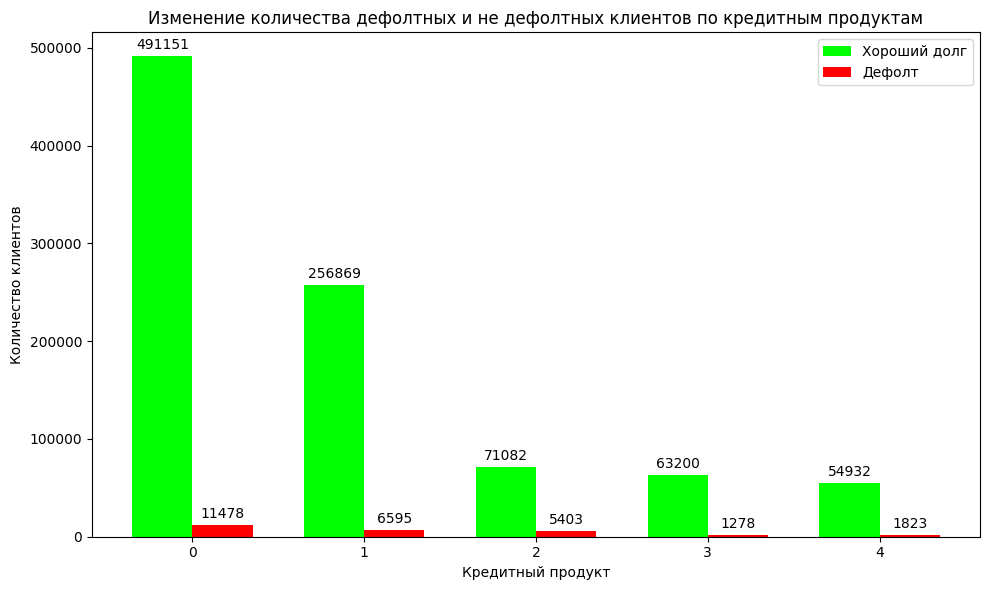

In [ ]:
# Группировка данных по кредитному продукту и подсчет количества дефолтных и не дефолтных клиентов
grouped = target_df.groupby('product')['flag'].value_counts().unstack(fill_value=0)

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
width = 0.35
indices = grouped.index
bar1 = plt.bar(indices - width/2, grouped[0], width, label='Хороший долг', color='#00FF00')
bar2 = plt.bar(indices + width/2, grouped[1], width, label='Дефолт', color='#FF0000')

plt.xlabel('Кредитный продукт')
plt.ylabel('Количество клиентов')
plt.title('Изменение количества дефолтных и не дефолтных клиентов по кредитным продуктам')
plt.xticks(indices)
plt.legend()

# Добавляем текстовые метки над каждым столбцом
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show()


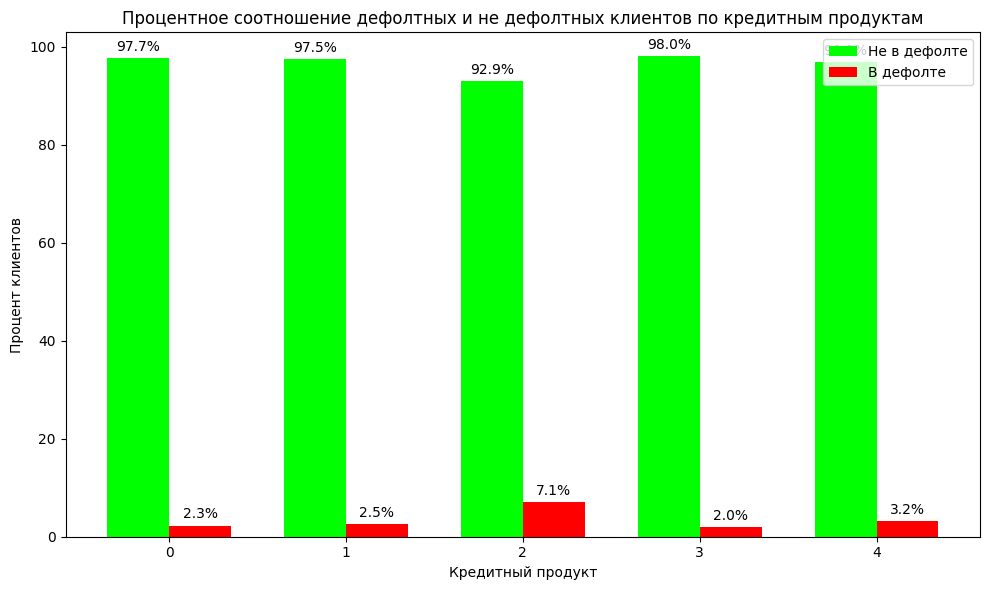

In [ ]:
# Группировка данных по кредитному продукту и вычисление процентного соотношения
grouped = target_df.groupby('product')['flag'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Создание столбчатой диаграммы
plt.figure(figsize=(10, 6))
width = 0.35
indices = grouped.index
bar1 = plt.bar(indices - width/2, grouped[0], width, label='Не в дефолте', color='#00FF00')
bar2 = plt.bar(indices + width/2, grouped[1], width, label='В дефолте', color='#FF0000')

plt.xlabel('Кредитный продукт')
plt.ylabel('Процент клиентов')
plt.title('Процентное соотношение дефолтных и не дефолтных клиентов по кредитным продуктам')
plt.xticks(indices)
plt.legend()

# Добавляем текстовые метки над каждым столбцом
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{:.1f}%'.format(height),
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.tight_layout()
plt.show()


### Транзакционные данные

#### Суммы транзакций


In [ ]:
def read_normalize_amnt_parquet(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле amnt и возвращает статистику для построения гистограммы.
    Пропуски (0.0) игнорируются.
    Возвращает общее количество транзакций и список количеств транзакций по интервалам для гистограммы.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    total_transactions = 0
    interval_counts = [0] * 10  # Для 10 интервалов гистограммы

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        amnt = df['amnt'].values
        amnt = amnt[amnt != 0.0]  # Удаляем пропуски (значения равные 0.0)

        total_transactions += len(amnt)

        # Рассчитываем интервалы и увеличиваем счетчики
        hist, _ = np.histogram(amnt, bins=10)
        interval_counts += hist

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return total_transactions, interval_counts


In [ ]:
# Подсчёт статистик нормализованных значений amnt
total_transactions, interval_counts = read_normalize_amnt_parquet(ALL_TRANSACTIONS_PATH)


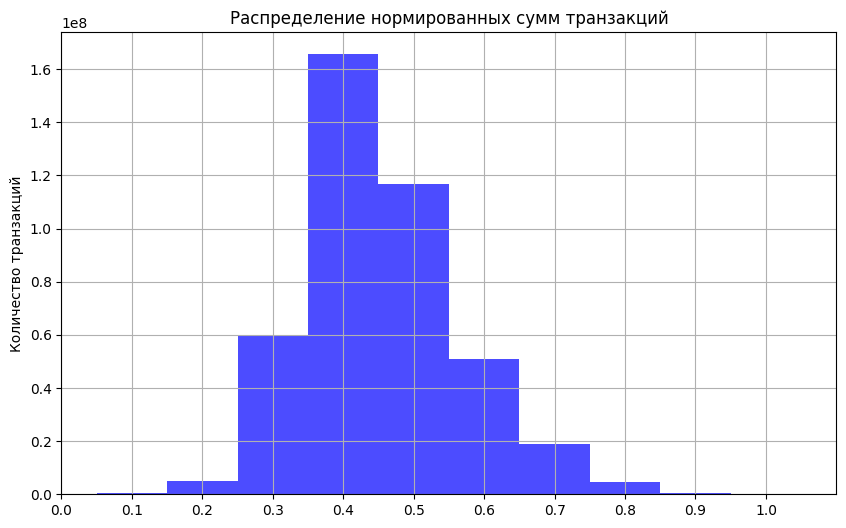

In [ ]:
plt.figure(figsize=(10, 6))

# Строим столбцы гистограммы с выравниванием по краю (align='edge') и шириной 1
plt.bar(np.arange(10) + 0.5, interval_counts, width=1, alpha=0.7, color='blue', align='edge')

plt.title('Распределение нормированных сумм транзакций')
plt.ylabel('Количество транзакций')

# Устанавливаем подписи на оси X с учетом смещения
plt.xticks(np.arange(11), [f'{i / 10:.1f}' for i in range(11)])

plt.grid(True)
plt.show()


#### Типы транзакций

In [ ]:
def read_operation_kind_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле operation_kind и возвращает распределение типов транзакций.
    Возвращает словарь, где ключи — типы транзакций, значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    operation_kind_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        operation_kind_counts_in_file = df['operation_kind'].value_counts()

        for operation_kind, count in operation_kind_counts_in_file.items():
            if operation_kind in operation_kind_counts:
                operation_kind_counts[operation_kind] += count
            else:
                operation_kind_counts[operation_kind] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return operation_kind_counts


In [ ]:
# Чтение распределения типов транзакций из тренировочной и тестовой выборок
operation_kind_distribution = read_operation_kind_distribution(ALL_TRANSACTIONS_PATH)


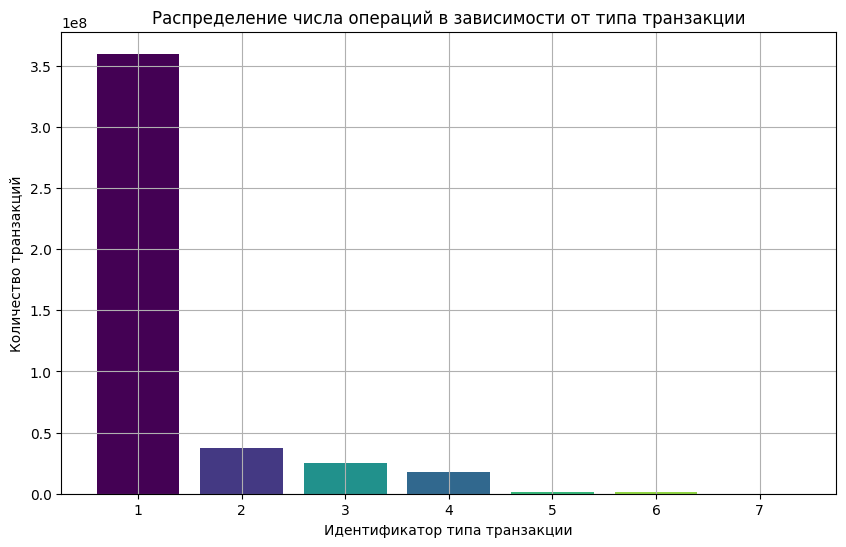

In [ ]:
# Построение гистограммы распределения типов транзакций
colors = plt.cm.viridis(np.linspace(0, 1, len(operation_kind_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(operation_kind_distribution.keys(), operation_kind_distribution.values(), color=colors)
plt.xlabel('Идентификатор типа транзакции')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от типа транзакции')
plt.xticks(list(operation_kind_distribution.keys()))
plt.grid(True)
plt.show()


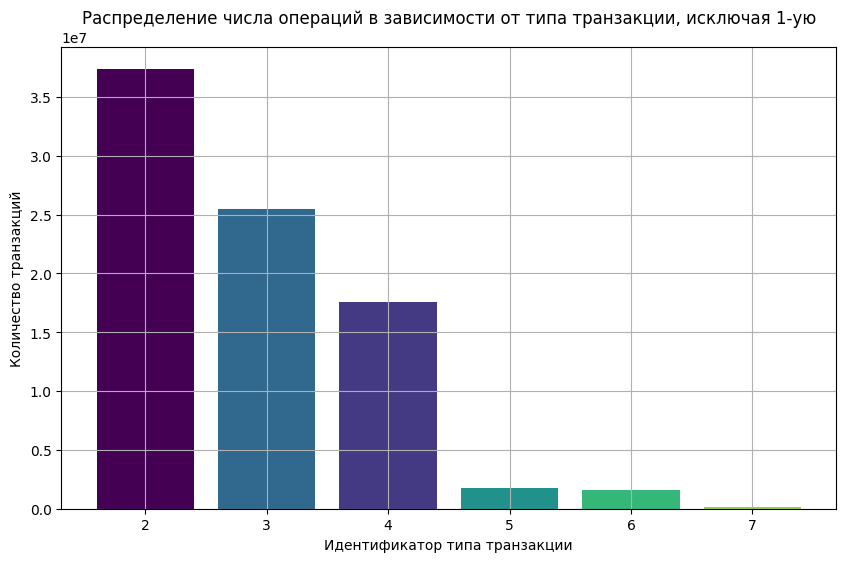

In [ ]:
# Создание копии словаря без ключа 1 (как строки и как числа)
filtered_operation_kind_distribution = {key: value for key, value in operation_kind_distribution.items() if key != '1' and key != 1}

# Построение гистограммы распределения типов транзакций
colors = plt.cm.viridis(np.linspace(0, 1, len(operation_kind_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(filtered_operation_kind_distribution.keys(), filtered_operation_kind_distribution.values(), color=colors)
plt.xlabel('Идентификатор типа транзакции')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от типа транзакции, исключая 1-ую')
plt.xticks(list(filtered_operation_kind_distribution.keys()))
plt.grid(True)
plt.show()


#### Валюты транзакций

In [ ]:
def read_currency_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле currency.
    Возвращает словарь, где ключи — идентификаторы валюты, значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    currency_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        currency_counts_in_file = df['currency'].value_counts()

        for currency_id, count in currency_counts_in_file.items():
            if currency_id in currency_counts:
                currency_counts[currency_id] += count
            else:
                currency_counts[currency_id] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return currency_counts


In [ ]:
# Чтение распределения валют из тренировочной и тестовой выборок
currency_distribution = read_currency_distribution(ALL_TRANSACTIONS_PATH)



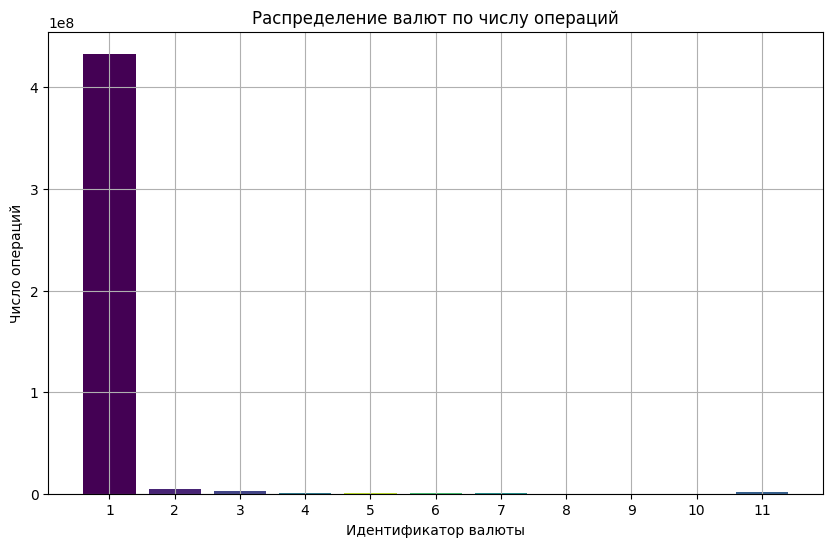

In [ ]:
# Генерация различных цветов для столбцов
colors = plt.cm.viridis(np.linspace(0, 1, len(currency_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(currency_distribution.keys(), currency_distribution.values(), color=colors)
plt.xlabel('Идентификатор валюты')
plt.ylabel('Число операций')
plt.title('Распределение валют по числу операций')
plt.xticks(list(currency_distribution.keys()))
plt.grid(True)
plt.show()


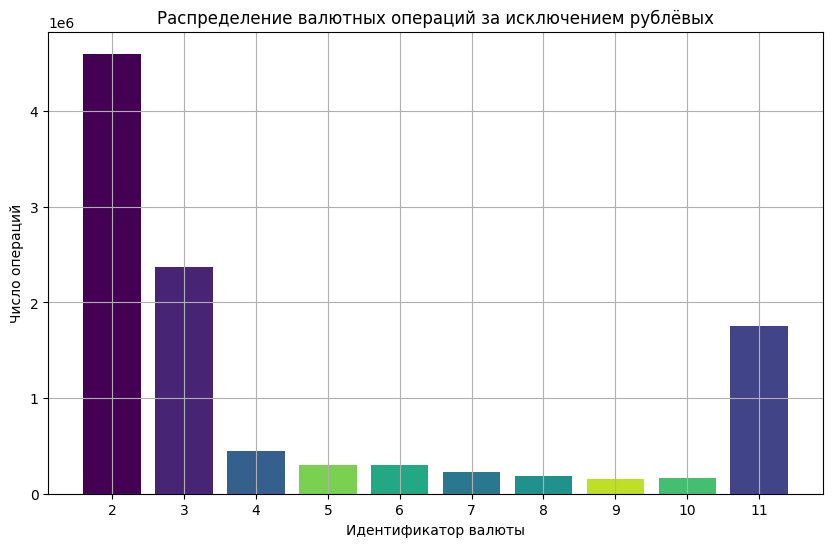

In [ ]:
# Создание копии словаря без ключа 1 (как строки и как числа)
filtered_currency_distribution = {key: value for key, value in currency_distribution.items() if key != '1' and key != 1}

# Генерация различных цветов для столбцов
colors = plt.cm.viridis(np.linspace(0, 1, len(currency_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(filtered_currency_distribution.keys(), filtered_currency_distribution.values(), color=colors)
plt.xlabel('Идентификатор валюты')
plt.ylabel('Число операций')
plt.title('Распределение валютных операций за исключением рублёвых')
plt.xticks(list(filtered_currency_distribution.keys()))
plt.grid(True)
plt.show()


#### Типы карт

In [ ]:
def read_operation_type_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле operation_type_group и возвращает распределение типов операций.
    Возвращает словарь, где ключи — типы операций, значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    operation_type_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        operation_type_counts_in_file = df['operation_type_group'].value_counts()

        for operation_type, count in operation_type_counts_in_file.items():
            if operation_type in operation_type_counts:
                operation_type_counts[operation_type] += count
            else:
                operation_type_counts[operation_type] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return operation_type_counts


In [ ]:
# Чтение распределения типов операций из тренировочной и тестовой выборок
operation_type_distribution = read_operation_type_distribution(ALL_TRANSACTIONS_PATH)


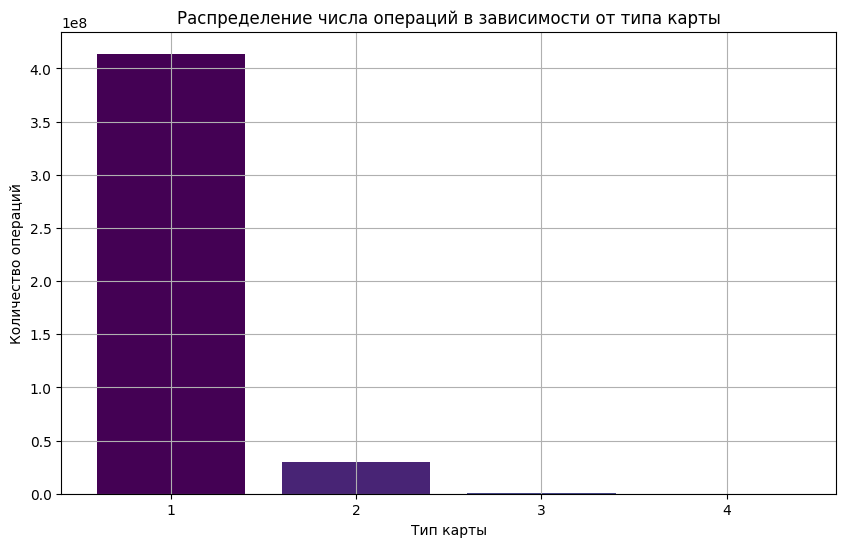

In [ ]:
# Построение гистограммы распределения типов операций
colors = plt.cm.viridis(np.linspace(0, 1, len(currency_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(operation_type_distribution.keys(), operation_type_distribution.values(), color=colors)
plt.xlabel('Тип карты')
plt.ylabel('Количество операций')
plt.title('Распределение числа операций в зависимости от типа карты')
plt.xticks(list(operation_type_distribution.keys()))
plt.grid(True)
plt.show()


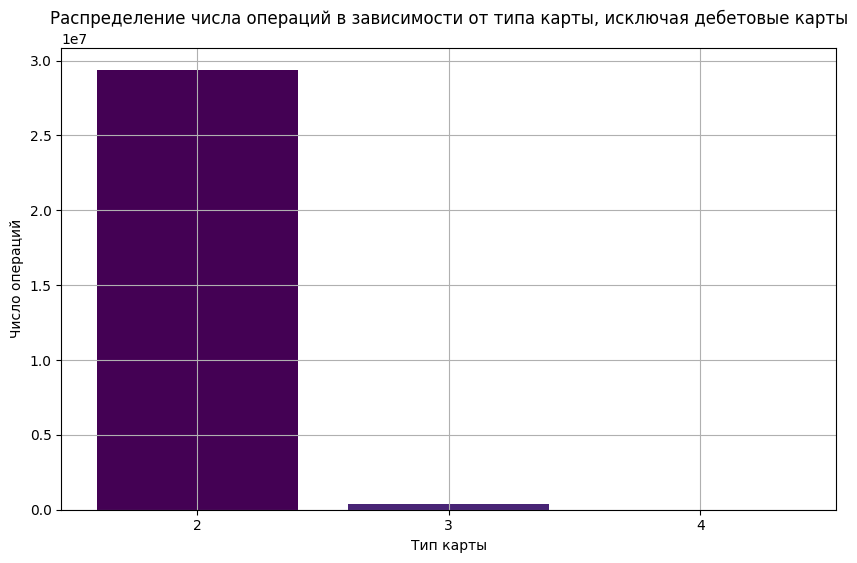

In [ ]:
# Создание копии словаря без ключа 1 (как строки и как числа)
filtered_operation_type_distribution = {key: value for key, value in operation_type_distribution.items() if key != '1' and key != 1}

# Генерация различных цветов для столбцов
colors = plt.cm.viridis(np.linspace(0, 1, len(currency_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(filtered_operation_type_distribution.keys(), filtered_operation_type_distribution.values(), color=colors)
plt.xlabel('Тип карты')
plt.ylabel('Число операций')
plt.title('Распределение числа операций в зависимости от типа карты, исключая дебетовые карты')
plt.xticks(list(filtered_operation_type_distribution.keys()))
plt.grid(True)
plt.show()


#### Электронная коммерция

In [ ]:
def read_ecommerce_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле ecommerce_flag и возвращает распределение признака электронной коммерции.
    Возвращает словарь, где ключи — значения ecommerce_flag (0 или 1), значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    ecommerce_counts = {0: 0, 1: 0}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        ecommerce_counts_in_file = df['ecommerce_flag'].value_counts()

        for flag, count in ecommerce_counts_in_file.items():
            if flag in ecommerce_counts:
                ecommerce_counts[flag] += count
            else:
                ecommerce_counts[flag] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return ecommerce_counts


In [ ]:
# Чтение распределения признака электронной коммерции из тренировочной и тестовой выборок
ecommerce_distribution = read_ecommerce_distribution(ALL_TRANSACTIONS_PATH)


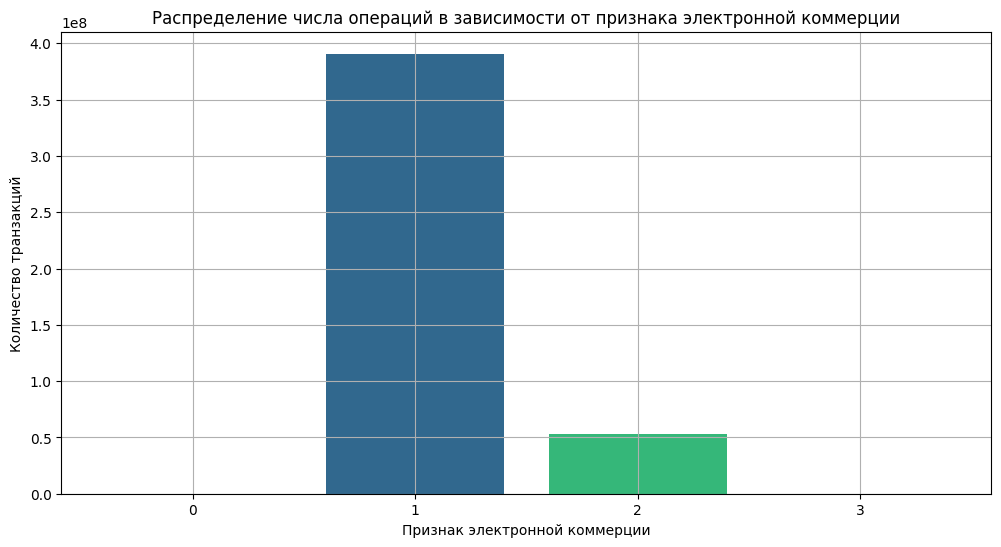

In [ ]:
# Построение гистограммы распределения признака электронной коммерции
colors = plt.cm.viridis(np.linspace(0, 1, len(ecommerce_distribution)))
plt.figure(figsize=(12, 6))
plt.bar(ecommerce_distribution.keys(), ecommerce_distribution.values(), color=colors)
plt.xlabel('Признак электронной коммерции')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от признака электронной коммерции')
plt.xticks(list(ecommerce_distribution.keys()))
plt.grid(True)
plt.show()


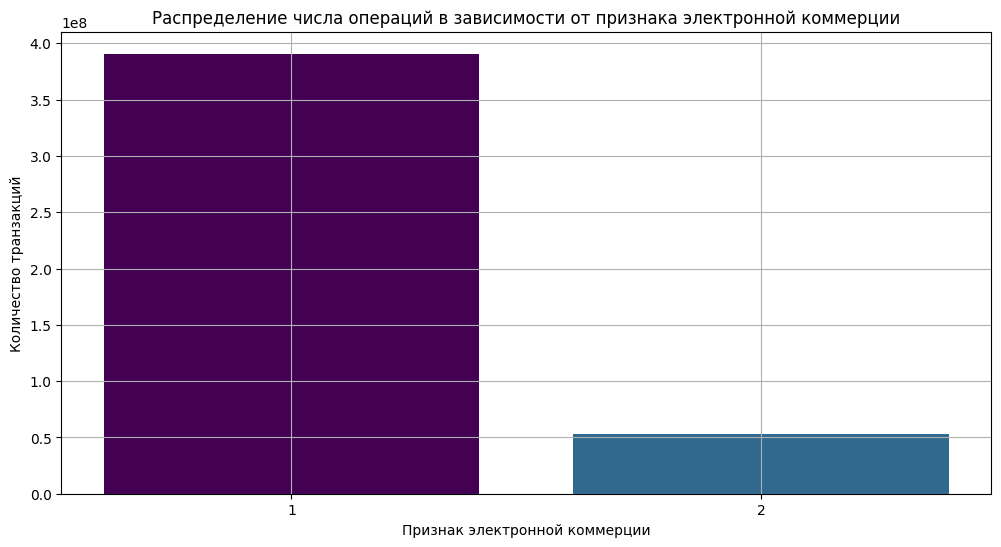

In [ ]:
# Отфильтруем только значения 1 и 2
filtered_distribution = {k: v for k, v in ecommerce_distribution.items() if k in [1, 2]}

# Построение гистограммы распределения признака электронной коммерции для значений 1 и 2
colors = plt.cm.viridis(np.linspace(0, 1, len(ecommerce_distribution)))
plt.figure(figsize=(12, 6))
plt.bar(filtered_distribution.keys(), filtered_distribution.values(), color=colors)
plt.xlabel('Признак электронной коммерции')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от признака электронной коммерции')
plt.xticks([1, 2])
plt.grid(True)
plt.show()


#### Типы платёжных систем

In [ ]:
def read_payment_system_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле payment_system и возвращает распределение типов платежных систем.
    Возвращает словарь, где ключи — типы платежных систем, значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    payment_system_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        payment_system_counts_in_file = df['payment_system'].value_counts()

        for payment_system, count in payment_system_counts_in_file.items():
            if payment_system in payment_system_counts:
                payment_system_counts[payment_system] += count
            else:
                payment_system_counts[payment_system] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return payment_system_counts


In [ ]:
# Чтение распределения типов платежных систем из тренировочной и тестовой выборок
payment_system_distribution = read_payment_system_distribution(ALL_TRANSACTIONS_PATH)


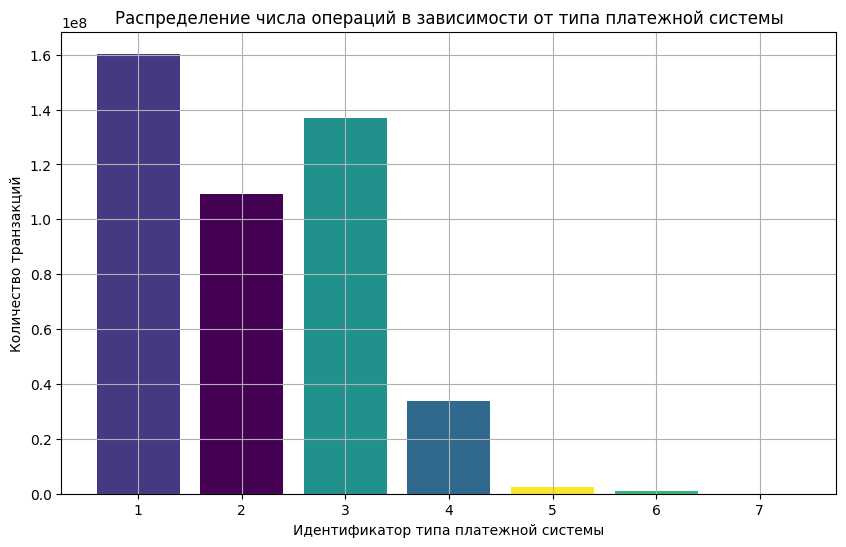

In [ ]:
# Построение гистограммы распределения типов платежных систем
colors = plt.cm.viridis(np.linspace(0, 1, len(payment_system_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(payment_system_distribution.keys(), payment_system_distribution.values(), color=colors)
plt.xlabel('Идентификатор типа платежной системы')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от типа платежной системы')
plt.xticks(list(payment_system_distribution.keys()))
plt.grid(True)
plt.show()


#### Страны

In [ ]:
def read_country_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле country и возвращает распределение стран транзакций.
    Возвращает словарь, где ключи — идентификаторы стран, значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    country_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        country_counts_in_file = df['country'].value_counts()

        for country, count in country_counts_in_file.items():
            if country in country_counts:
                country_counts[country] += count
            else:
                country_counts[country] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return country_counts


In [ ]:
# Чтение распределения стран транзакций из тренировочной и тестовой выборок
country_distribution = read_country_distribution(ALL_TRANSACTIONS_PATH)


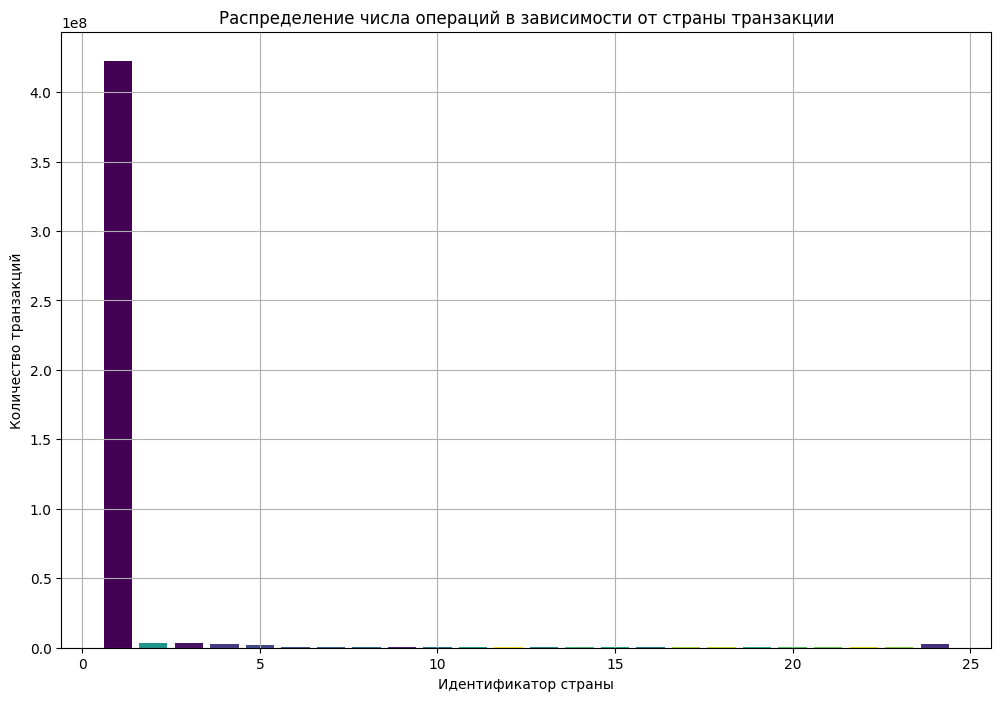

In [ ]:
# Построение гистограммы распределения стран транзакций
colors = plt.cm.viridis(np.linspace(0, 1, len(country_distribution)))
plt.figure(figsize=(12, 8))
plt.bar(country_distribution.keys(), country_distribution.values(), color=colors)
plt.xlabel('Идентификатор страны')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от страны транзакции')
plt.grid(True)
plt.show()


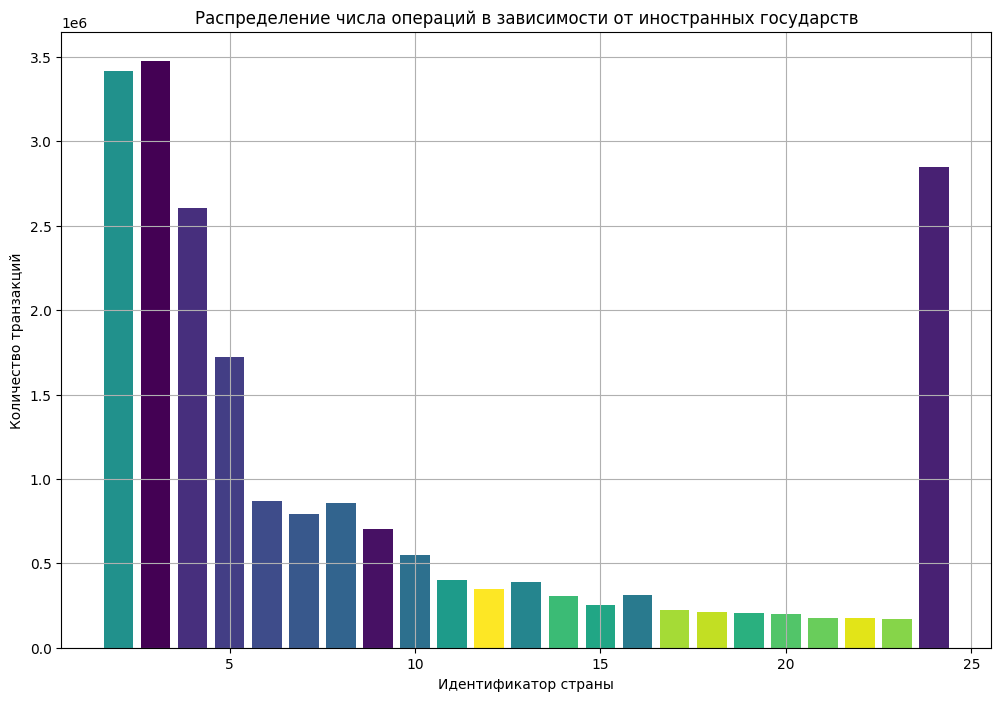

In [ ]:
# Создание копии словаря без ключа 1 (как строки и как числа)
filtered_country_distribution = {key: value for key, value in country_distribution.items() if key != '1' and key != 1}

# Построение гистограммы распределения стран транзакций
colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_country_distribution)))
plt.figure(figsize=(12, 8))
plt.bar(filtered_country_distribution.keys(), filtered_country_distribution.values(), color=colors)
plt.xlabel('Идентификатор страны')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от иностранных государств')
plt.grid(True)
plt.show()


#### Города

In [ ]:
def read_city_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле city и возвращает распределение городов транзакций.
    Возвращает словарь, где ключи — идентификаторы городов, значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    city_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        city_counts_in_file = df['city'].value_counts()

        for city, count in city_counts_in_file.items():
            if city in city_counts:
                city_counts[city] += count
            else:
                city_counts[city] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return city_counts


In [ ]:
# Чтение распределения городов из тренировочной и тестовой выборок
city_distribution = read_city_distribution(ALL_TRANSACTIONS_PATH)


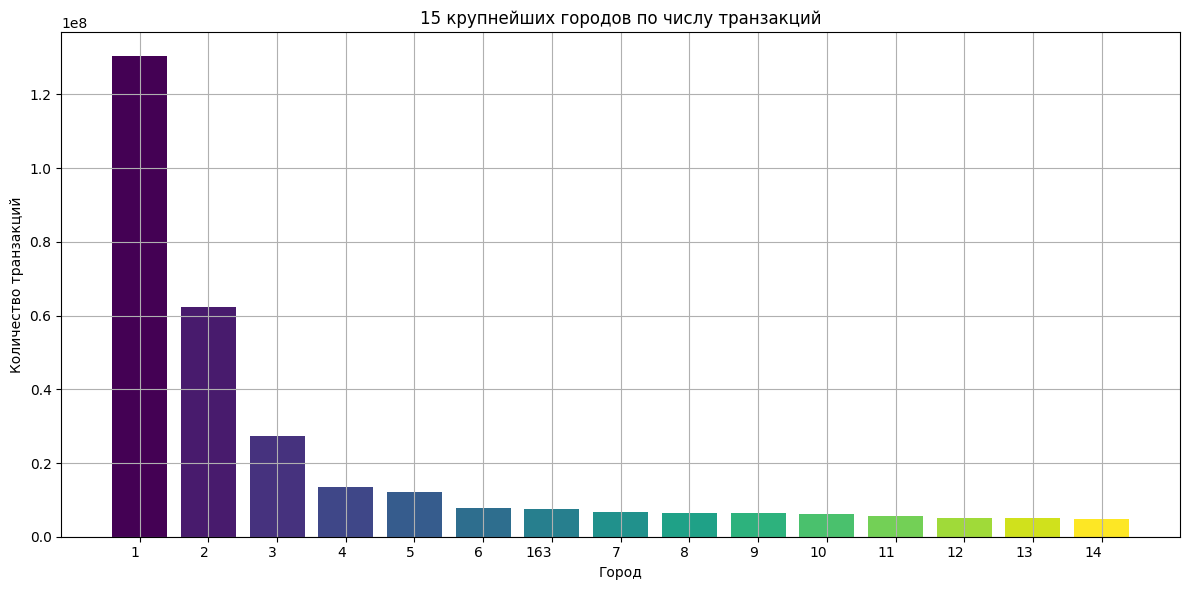

In [ ]:
# Получение 25 городов с наибольшим числом транзакций
top_cities = sorted(city_distribution.items(), key=lambda x: x[1], reverse=True)[:15]
top_cities_names = [city for city, count in top_cities]
top_cities_counts = [count for city, count in top_cities]

# Создание порядкового номера для каждого города
city_indices = range(1, len(top_cities_names) + 1)

# Построение гистограммы распределения городов
colors = plt.cm.viridis(np.linspace(0, 1, len(top_cities)))
plt.figure(figsize=(12, 6))
plt.bar(city_indices, top_cities_counts, color=colors)
plt.xlabel('Город')
plt.ylabel('Количество транзакций')
plt.title('15 крупнейших городов по числу транзакций')
plt.xticks(city_indices, top_cities_names, ha='right')
plt.grid(True)
plt.tight_layout()  # Улучшает отображение графика
plt.show()


#### Категории магазинов

In [ ]:
def read_mcc_category_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле mcc_category и возвращает распределение категорий MCC.
    Возвращает словарь, где ключи — идентификаторы категорий MCC, значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    mcc_category_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        mcc_category_counts_in_file = df['mcc_category'].value_counts()

        for mcc_category, count in mcc_category_counts_in_file.items():
            if mcc_category in mcc_category_counts:
                mcc_category_counts[mcc_category] += count
            else:
                mcc_category_counts[mcc_category] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return mcc_category_counts


In [ ]:
# Чтение распределения категорий MCC из тренировочной и тестовой выборок
mcc_category_distribution = read_mcc_category_distribution(ALL_TRANSACTIONS_PATH)


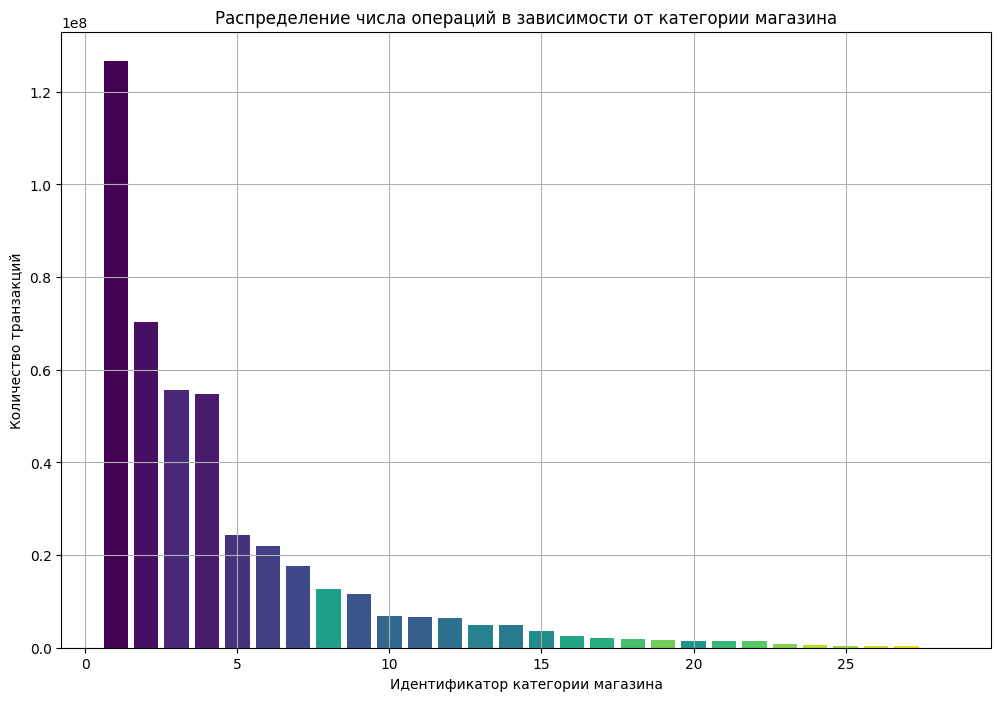

In [ ]:
# Построение гистограммы распределения категорий MCC
colors = plt.cm.viridis(np.linspace(0, 1, len(mcc_category_distribution)))
plt.figure(figsize=(12, 8))
plt.bar(mcc_category_distribution.keys(), mcc_category_distribution.values(), color=colors)
plt.xlabel('Идентификатор категории магазина')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от категории магазина')
plt.grid(True)
plt.show()


#### Дни недели

In [ ]:
def read_day_of_week_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле day_of_week и возвращает распределение дней недели транзакций.
    Возвращает словарь, где ключи — дни недели (0-6, где 0 - понедельник, 6 - воскресенье), значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    day_of_week_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        day_of_week_counts_in_file = df['day_of_week'].value_counts()

        for day_of_week, count in day_of_week_counts_in_file.items():
            if day_of_week in day_of_week_counts:
                day_of_week_counts[day_of_week] += count
            else:
                day_of_week_counts[day_of_week] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return day_of_week_counts


In [ ]:
# Чтение распределения дней недели из тренировочной и тестовой выборок
day_of_week_distribution = read_day_of_week_distribution(ALL_TRANSACTIONS_PATH)


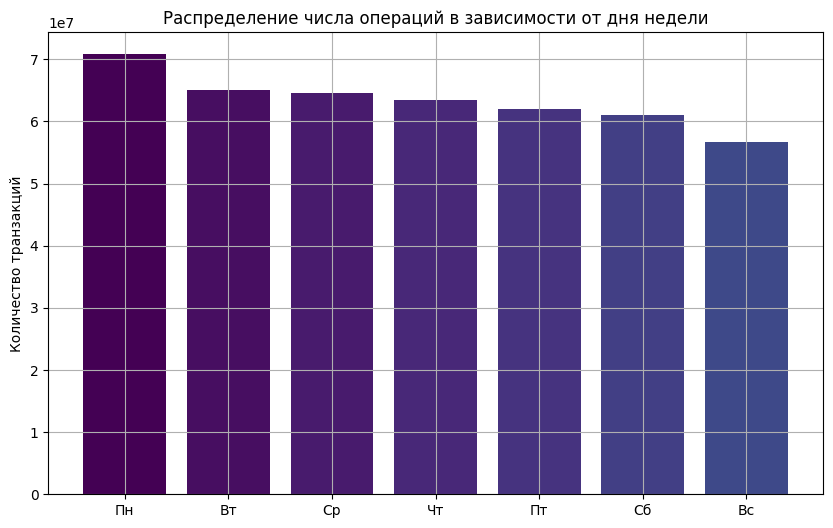

In [ ]:
# Построение гистограммы распределения дней недели
colors = plt.cm.viridis(np.linspace(0, 1, len(mcc_category_distribution)))
plt.figure(figsize=(10, 6))
plt.bar(day_of_week_distribution.keys(), day_of_week_distribution.values(), color=colors)
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от дня недели')
plt.xticks(range(1,8), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(True)
plt.show()


#### Часы суток

In [ ]:
def read_hour_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле hour и возвращает распределение часов транзакций.
    Возвращает словарь, где ключи — часы (от 0 до 23), значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    hour_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        hour_counts_in_file = df['hour'].value_counts()

        for hour, count in hour_counts_in_file.items():
            if hour in hour_counts:
                hour_counts[hour] += count
            else:
                hour_counts[hour] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return hour_counts


In [ ]:
# Чтение распределения часов из тренировочной и тестовой выборок
hour_distribution = read_hour_distribution(ALL_TRANSACTIONS_PATH)


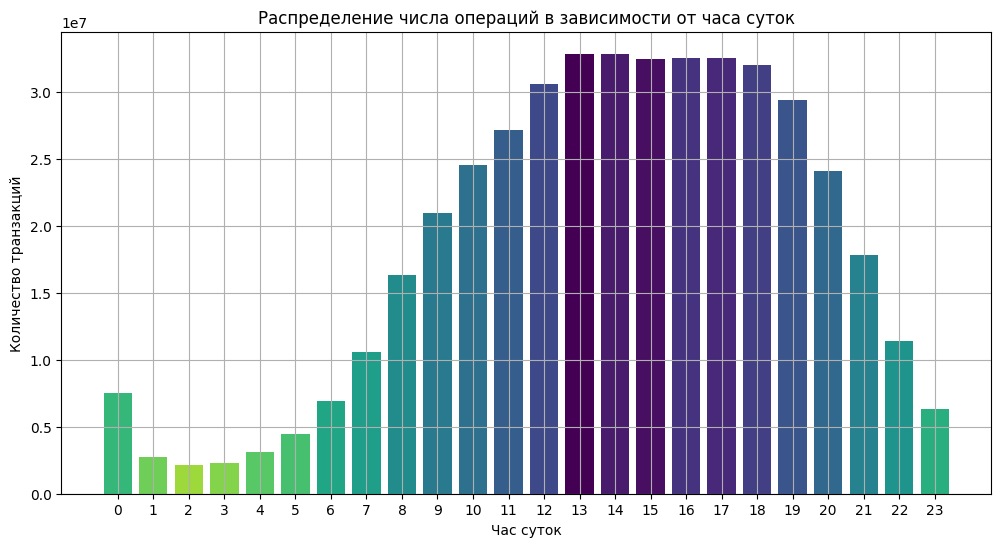

In [ ]:
# Построение гистограммы распределения часов транзакций
colors = plt.cm.viridis(np.linspace(0, 1, len(mcc_category_distribution)))
plt.figure(figsize=(12, 6))
plt.bar(hour_distribution.keys(), hour_distribution.values(), color=colors)
plt.xlabel('Час суток')
plt.ylabel('Количество транзакций')
plt.title('Распределение числа операций в зависимости от часа суток')
plt.xticks(range(24))
plt.grid(True)
plt.show()


#### Годовой временной ряд

In [ ]:
def read_weekofyear_distribution(path_to_dataset):
    """
    Читает .parquet файлы из указанной директории, извлекает поле weekofyear и возвращает распределение номеров недель транзакций.
    Возвращает словарь, где ключи — номера недель (от 1 до 52), значения — количество транзакций.
    """
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                            if filename.endswith('.parquet')])

    weekofyear_counts = {}

    for file_path in dataset_paths:
        df = pd.read_parquet(file_path)
        weekofyear_counts_in_file = df['weekofyear'].value_counts()

        for weekofyear, count in weekofyear_counts_in_file.items():
            if weekofyear in weekofyear_counts:
                weekofyear_counts[weekofyear] += count
            else:
                weekofyear_counts[weekofyear] = count

        del df  # Удаляем DataFrame, чтобы освободить память
        gc.collect()

    return weekofyear_counts


In [ ]:
# Чтение распределения номеров недель из тренировочной и тестовой выборок
weekofyear_distribution = read_weekofyear_distribution(ALL_TRANSACTIONS_PATH)


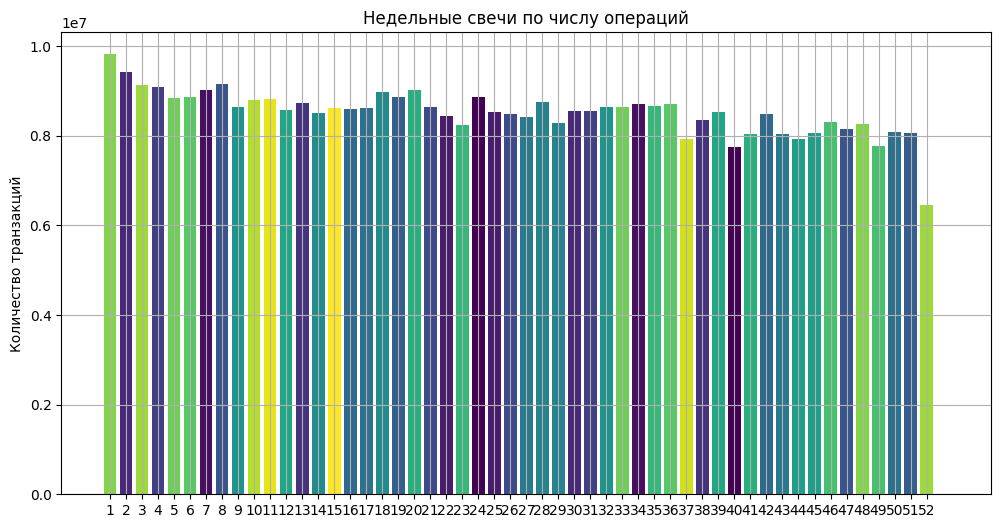

In [ ]:
# Построение гистограммы распределения номеров недель транзакций
colors = plt.cm.viridis(np.linspace(0, 1, len(mcc_category_distribution)))
plt.figure(figsize=(12, 6))
plt.bar(weekofyear_distribution.keys(), weekofyear_distribution.values(), color=colors)
plt.ylabel('Количество транзакций')
plt.title('Недельные свечи по числу операций')
plt.xticks(range(1, 53))  # Номера недель от 1 до 52
plt.grid(True)
plt.show()


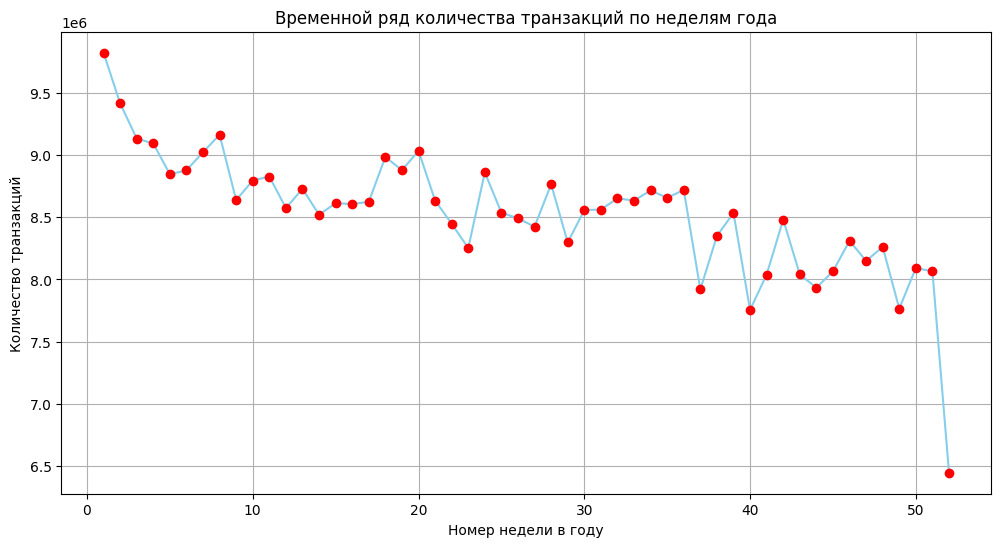

In [ ]:
# Сортировка данных по ключам (номерам недель) для корректного построения временного ряда
sorted_weekofyear = sorted(weekofyear_distribution.items())
weeks = [week for week, count in sorted_weekofyear]
transaction_counts = [count for week, count in sorted_weekofyear]

# Удаление последнего значения правого 0-ого значения
weeks = weeks[:-1]
transaction_counts = transaction_counts[:-1]

# Построение графика временного ряда
plt.figure(figsize=(12, 6))
plt.plot(weeks, transaction_counts, marker='o', linestyle='-', color='skyblue', markerfacecolor='red', markeredgecolor='red')
plt.xlabel('Номер недели в году')
plt.ylabel('Количество транзакций')
plt.title('Временной ряд количества транзакций по неделям года')
plt.grid(True)
plt.show()
